In [2]:
# Main Library
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from skimage import color, filters
from tqdm import tqdm
import imgaug.augmenters as iaa
import random

# Preprocessing In Data.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV

# metrics 
from sklearn.metrics import (confusion_matrix, roc_curve, auc, roc_auc_score, 
                             precision_recall_curve, average_precision_score,classification_report,
                             make_scorer, balanced_accuracy_score)
# Model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
# deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

# load the data

In [3]:
train_path = r'/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset'
Categories = [Class for Class in os.listdir(train_path)]

train_data = []

# Define your augmentation sequence
augment = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),  # Random rotation between -25 and 25 degrees
    iaa.Fliplr(0.5),  # Horizontal flip with a probability of 50%
    iaa.Flipud(0.3),  # Vertical flip with a probability of 30%
    iaa.Multiply((0.8, 1.2)),  # Change brightness by 80% to 120%
    iaa.Affine(scale=(0.8, 1.2))  # Random scaling between 80% and 120%
])

for category in Categories:
    label = Categories.index(category)
    path = os.path.join(train_path, category)
    
    for img in os.listdir(path):
        image = os.path.join(path, img)
        try:
            the_img = cv2.imread(image, 0)
            the_img = cv2.resize(the_img, (150, 150))
            
            # Append the original image
            train_data.append([the_img, label])
            
            # Augment the image 
            augmented_images = augment(images=[the_img] * 1)  # Generating 1 augmented images
            for aug_img in augmented_images:
                train_data.append([aug_img, label])

        except Exception as ex:
            pass

# Shuffle the augmented dataset
random.shuffle(train_data)


<img src="https://viso.ai/wp-content/uploads/2022/06/image-dataset-and-data-augmentation-concept.jpg" width="1200" height="300">


In [4]:
Categories

['Car', 'Bike']

# Split the data

In [5]:
# On The Train Data
train_imgs = []
train_labels = []

for features, labels in train_data:
    train_imgs.append(features)
    train_labels.append(labels)
    
train_imgs = np.array(train_imgs) # Features
train_labels = np.array(train_labels) # Targets

from sklearn.utils import shuffle

# Assuming X_train and y_train are already populated
train_imgs, train_labels = shuffle(train_imgs, train_labels)

In [6]:
# shapes
print(f"X_train shape is {train_imgs.shape}")
print(f"y_train shape is {train_labels.shape}")

X_train shape is (8000, 150, 150)
y_train shape is (8000,)


# Some image preprocessing

In [7]:
for i in range(len(train_imgs)):
    # Apply Gaussian blur
    train_imgs[i] = cv2.GaussianBlur(train_imgs[i], (5, 5), 0)

<img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/eqns/eqngaus1.gif" width="1200" height="300">


# EDA

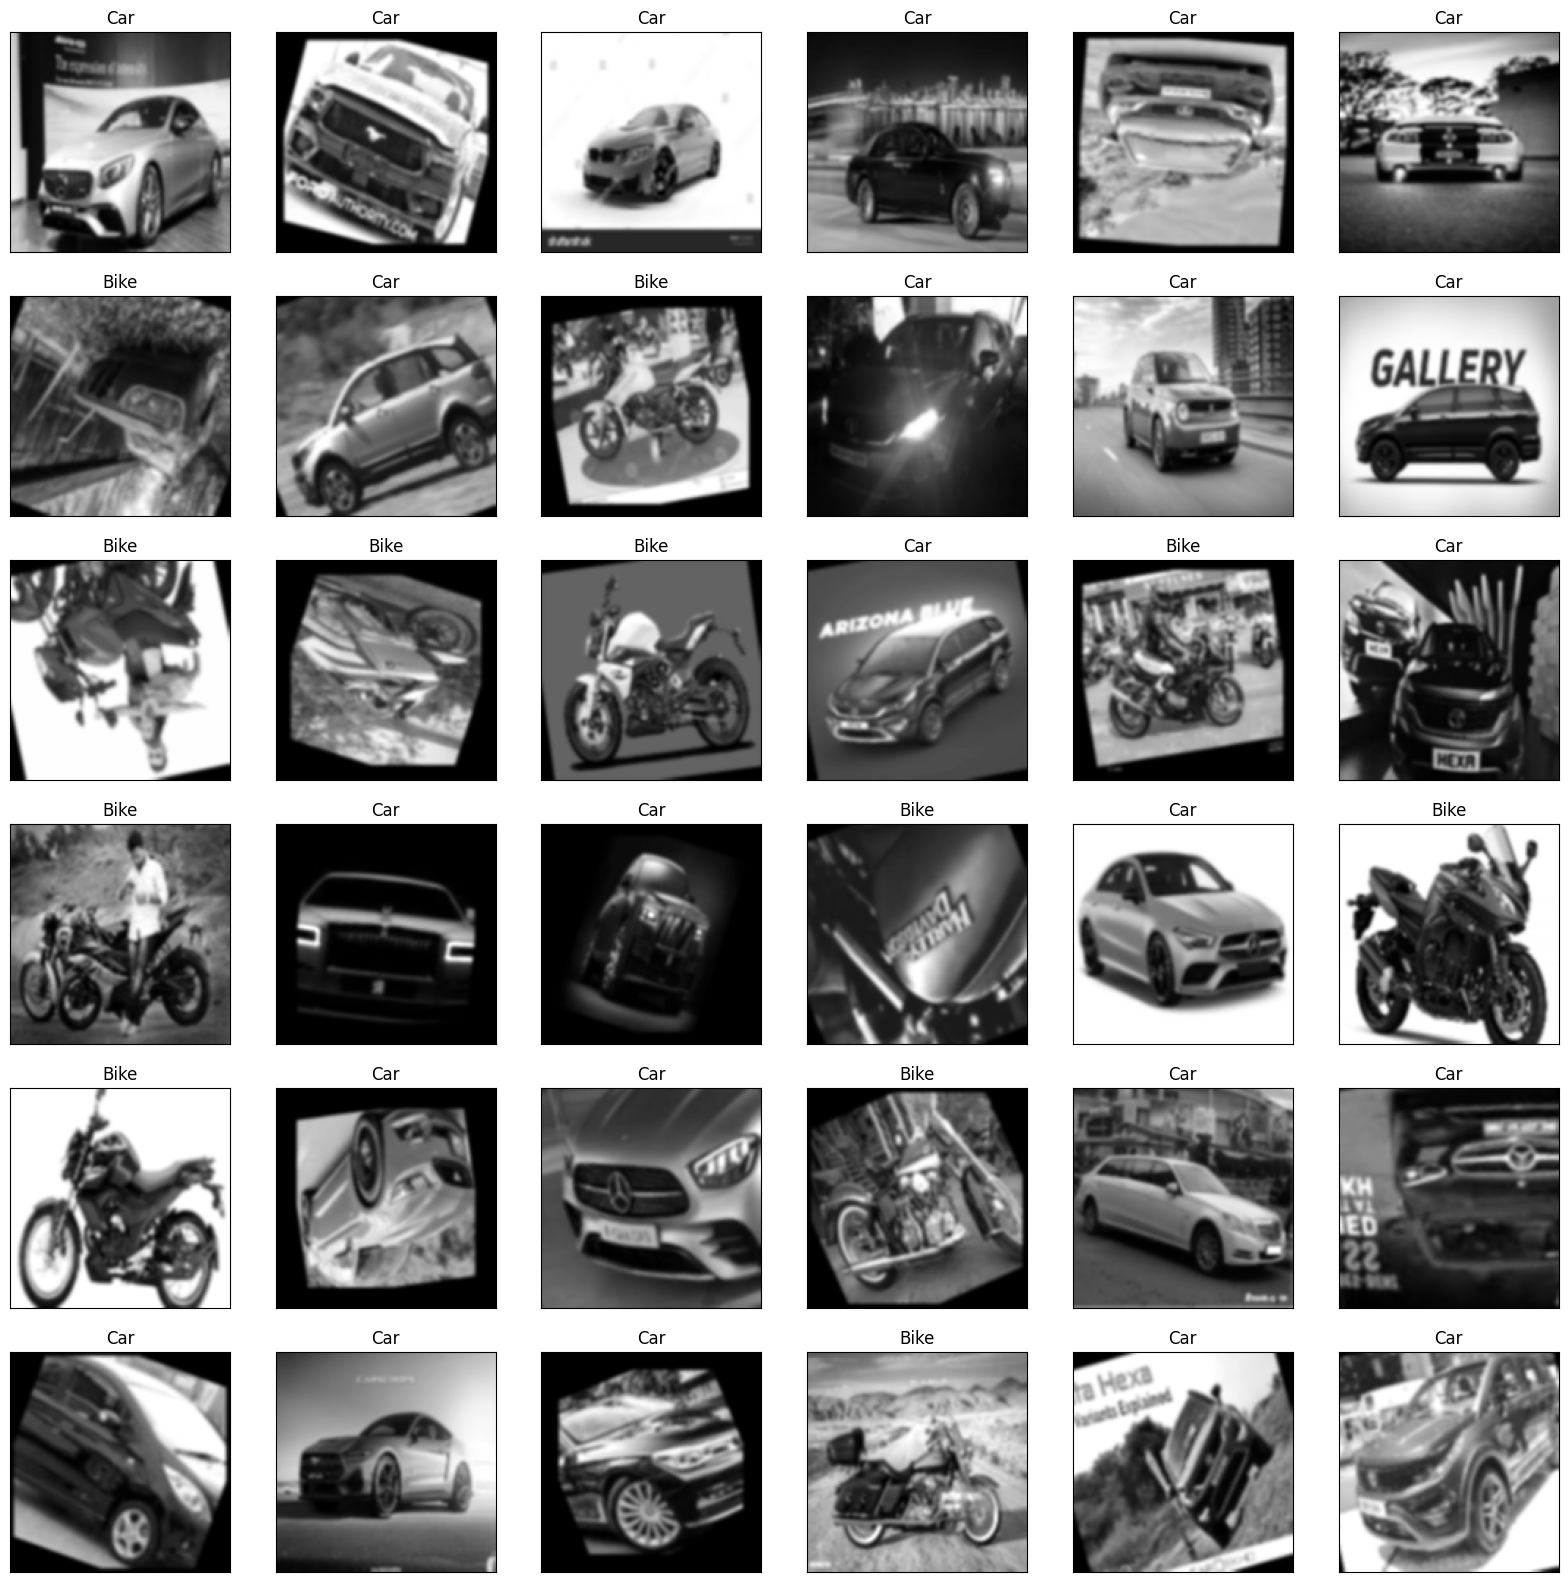

In [8]:
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(train_imgs[i], cmap="gray")
    plt.title(f"{Categories[train_labels[i]]}")
    plt.xticks([])
    plt.yticks([])
    
plt.show()

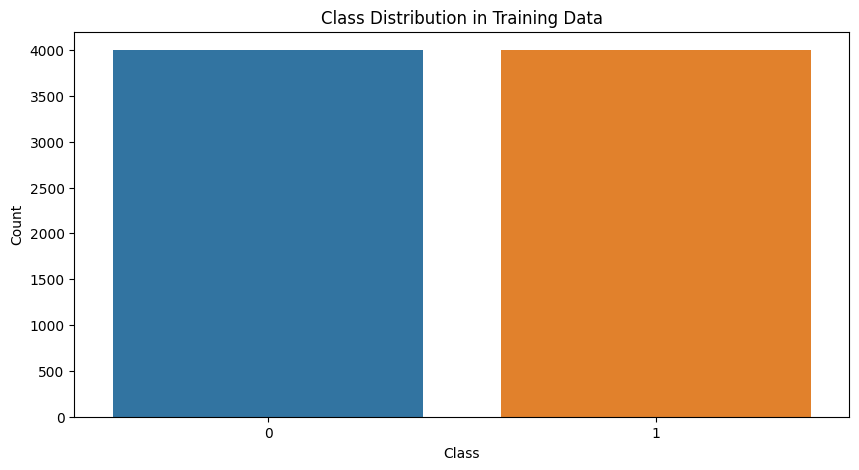

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(x=train_labels)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

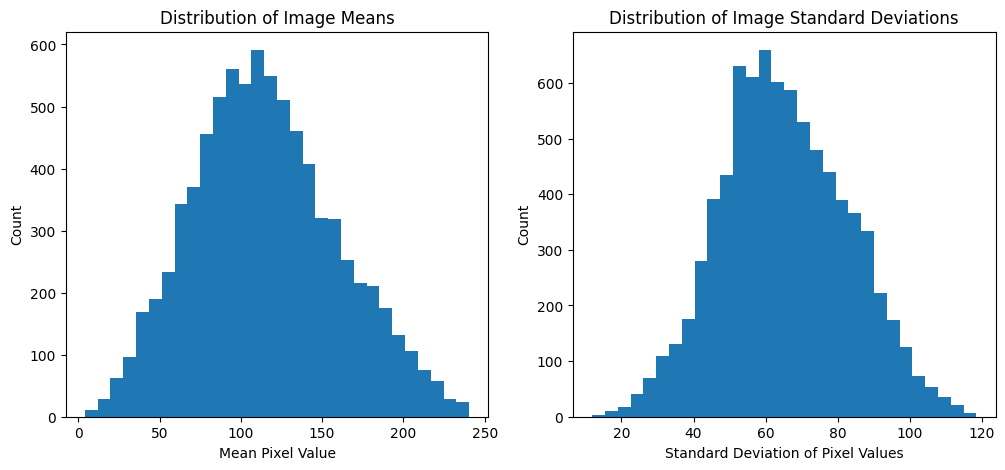

In [10]:
image_means = [np.mean(image) for image in train_imgs]
image_stds = [np.std(image) for image in train_imgs]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(image_means, bins=30)
plt.title('Distribution of Image Means')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(image_stds, bins=30)
plt.title('Distribution of Image Standard Deviations')
plt.xlabel('Standard Deviation of Pixel Values')
plt.ylabel('Count')

plt.show()

# Feature Extraction

## HOG

<img src="https://media.licdn.com/dms/image/v2/D4D12AQHv8ERHszhK-A/article-inline_image-shrink_1000_1488/article-inline_image-shrink_1000_1488/0/1715449740592?e=1739404800&v=beta&t=R4pLOLn_9A-vTp5kLnjn_lYEXEg15GJGijbmQjMlIk4" width="1200" height="300">


Processing images:   0%|          | 0/8000 [00:00<?, ?it/s]

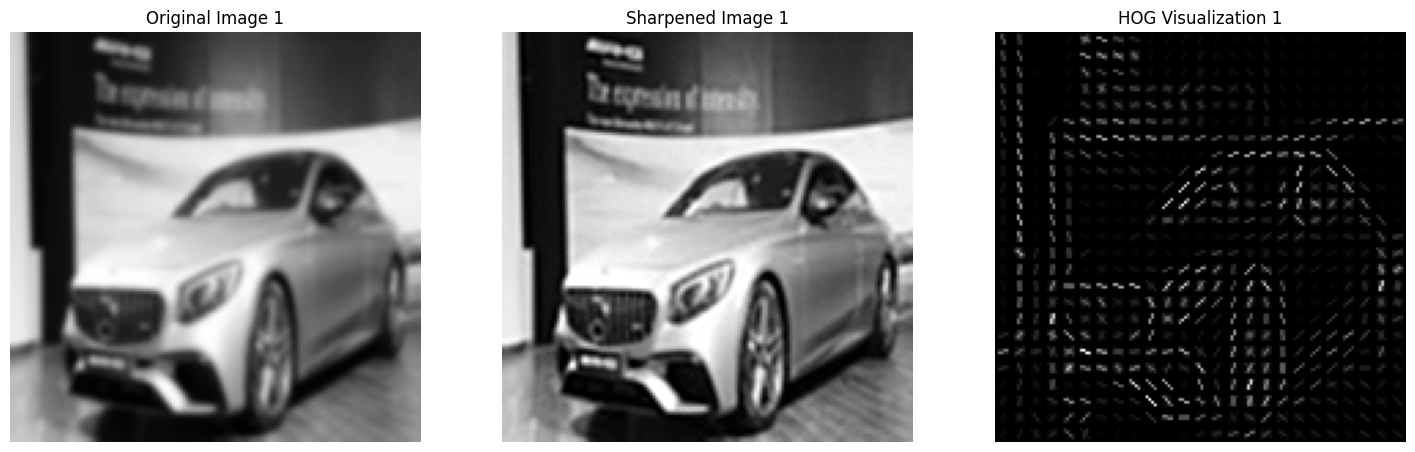

Processing images:   0%|          | 1/8000 [00:00<1:43:20,  1.29it/s]

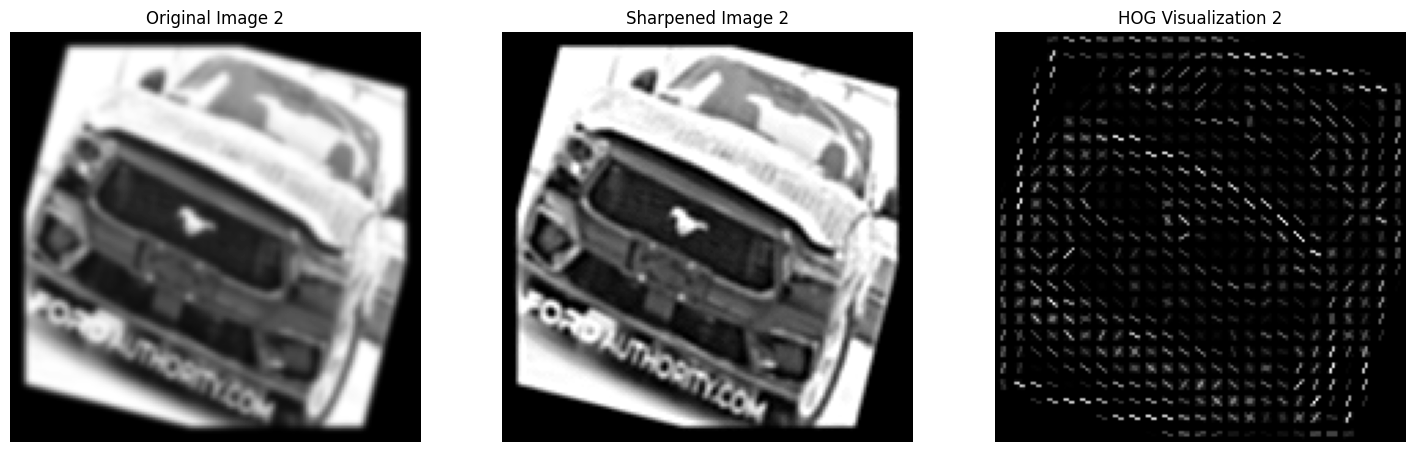

Processing images:   0%|          | 2/8000 [00:01<1:41:22,  1.31it/s]

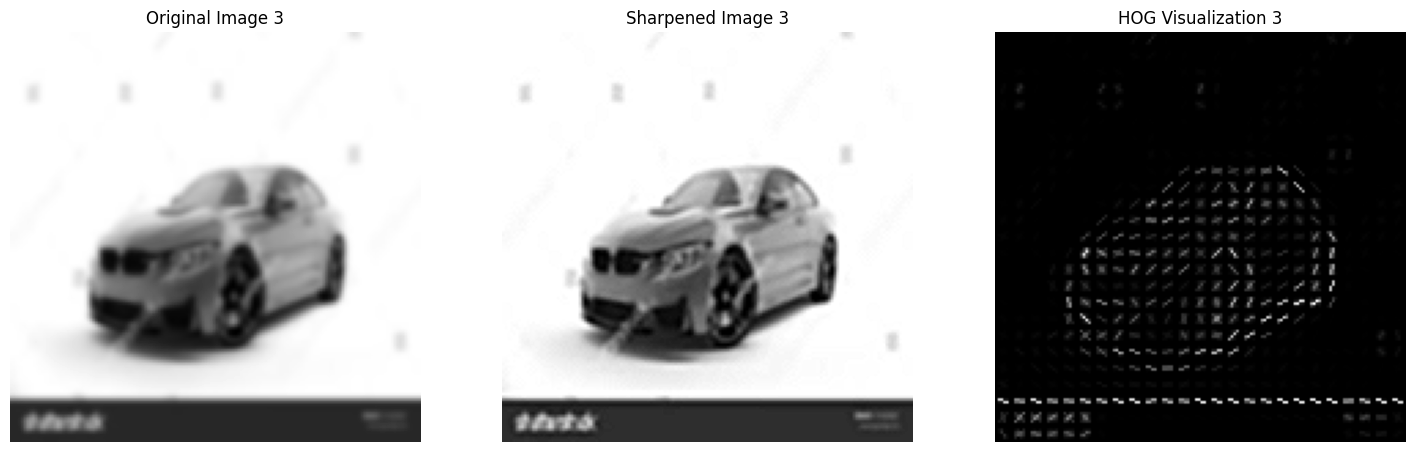

Processing images:   0%|          | 3/8000 [00:02<1:43:41,  1.29it/s]

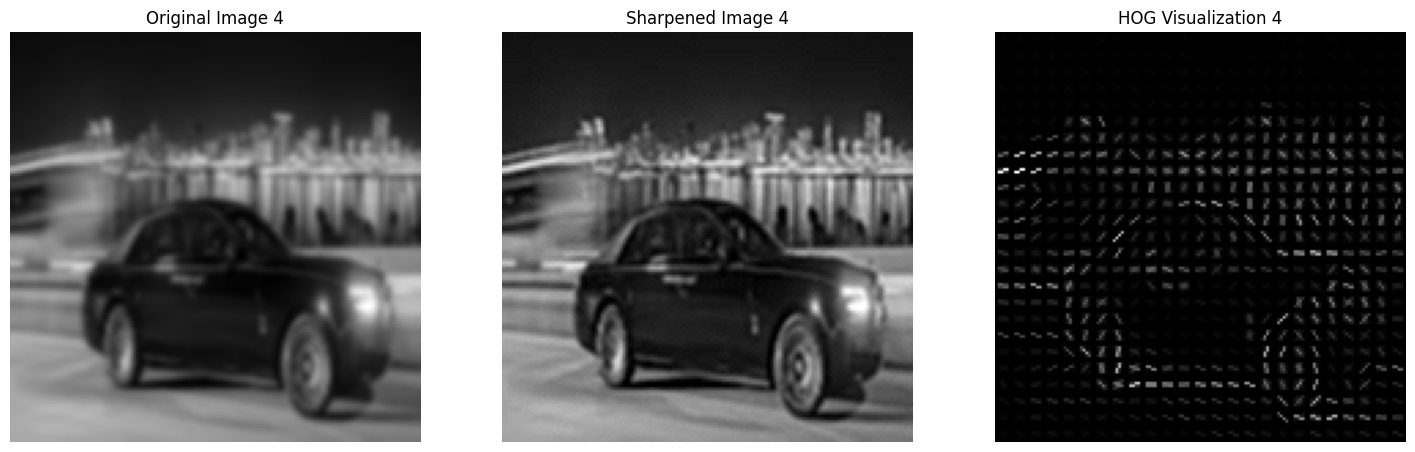

Processing images:   0%|          | 4/8000 [00:03<1:47:36,  1.24it/s]

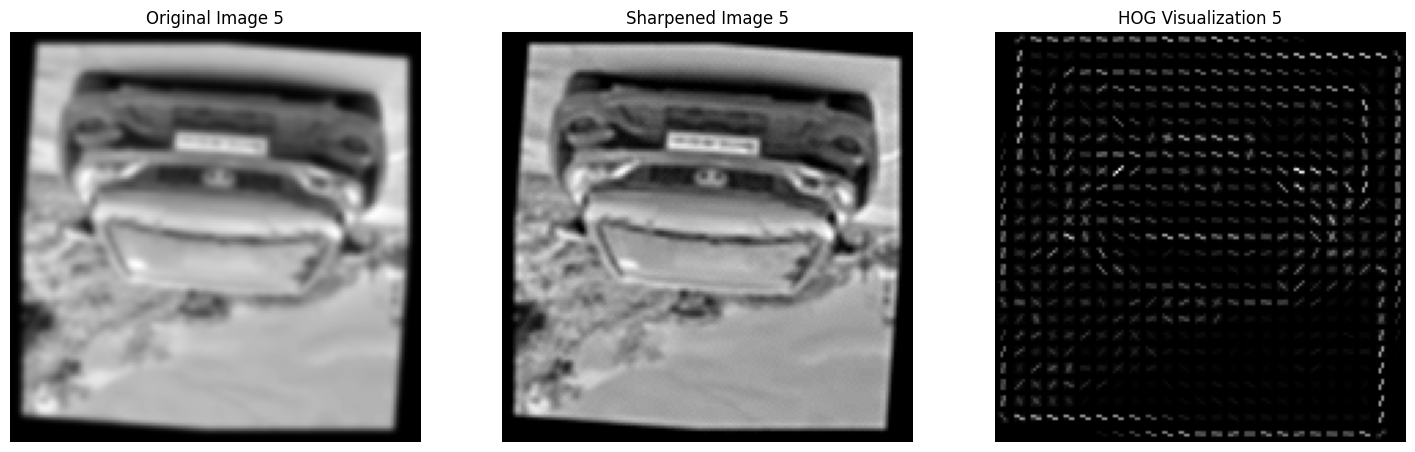

Processing images:   0%|          | 5/8000 [00:03<1:47:40,  1.24it/s]

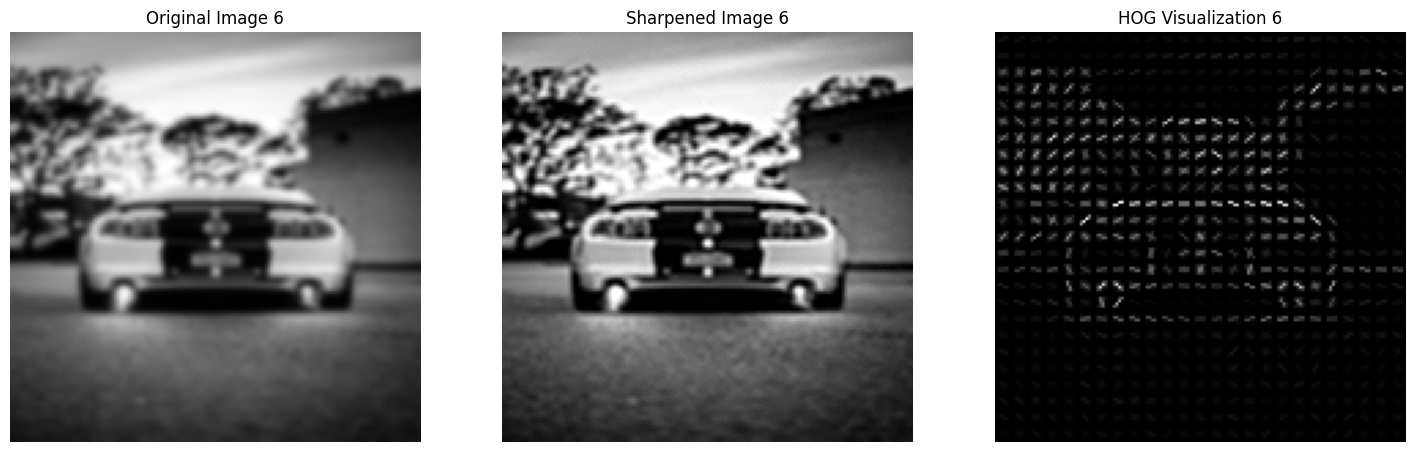

Processing images:   0%|          | 6/8000 [00:04<1:47:51,  1.24it/s]

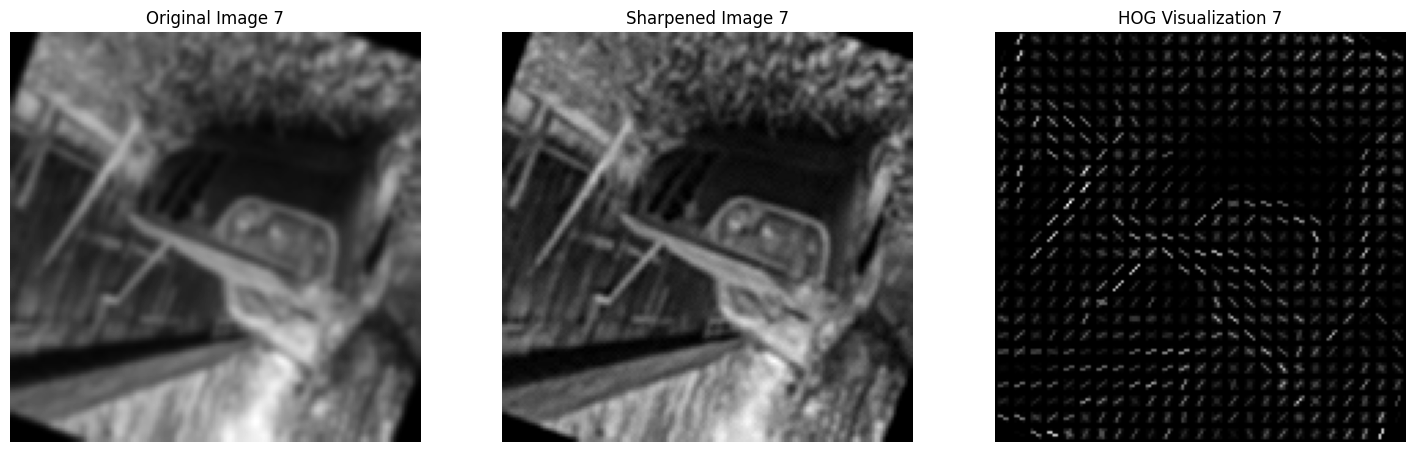

Processing images:   0%|          | 7/8000 [00:05<1:49:35,  1.22it/s]

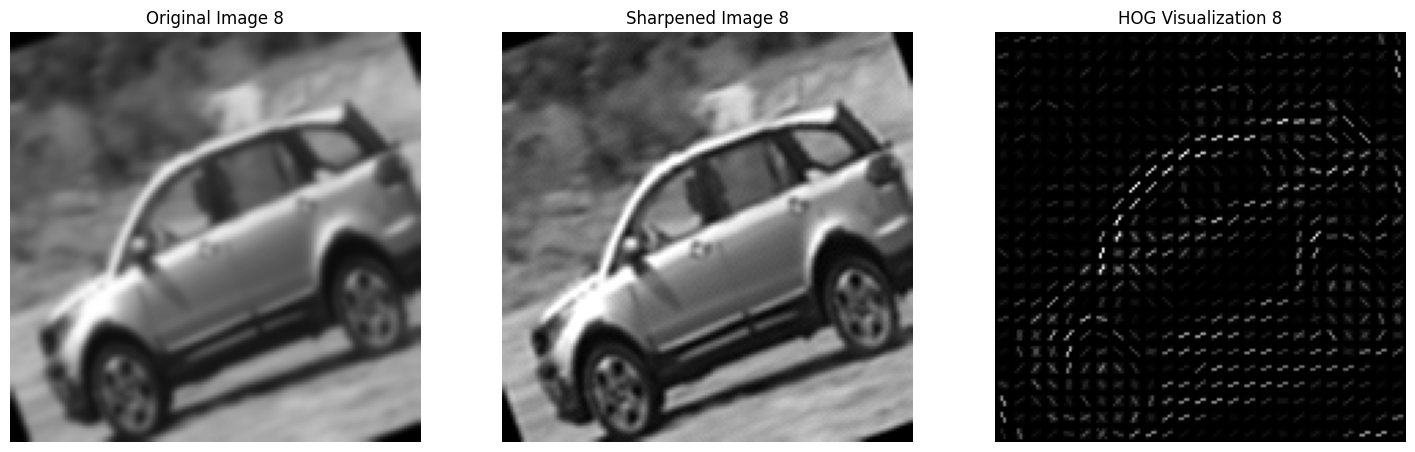

Processing images:   0%|          | 8/8000 [00:06<1:49:32,  1.22it/s]

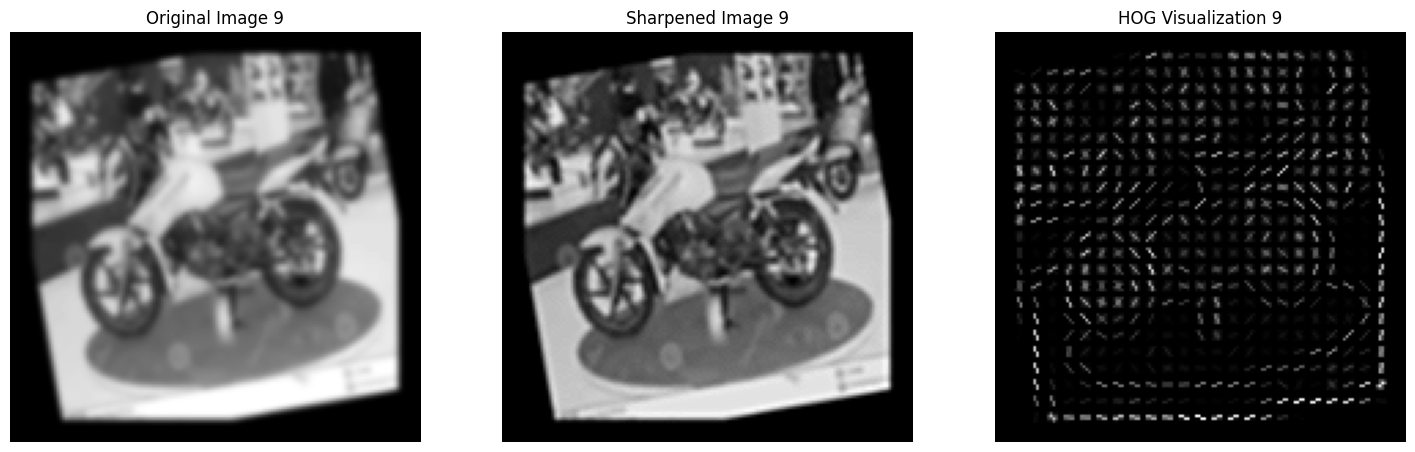

Processing images:   0%|          | 9/8000 [00:07<1:48:13,  1.23it/s]

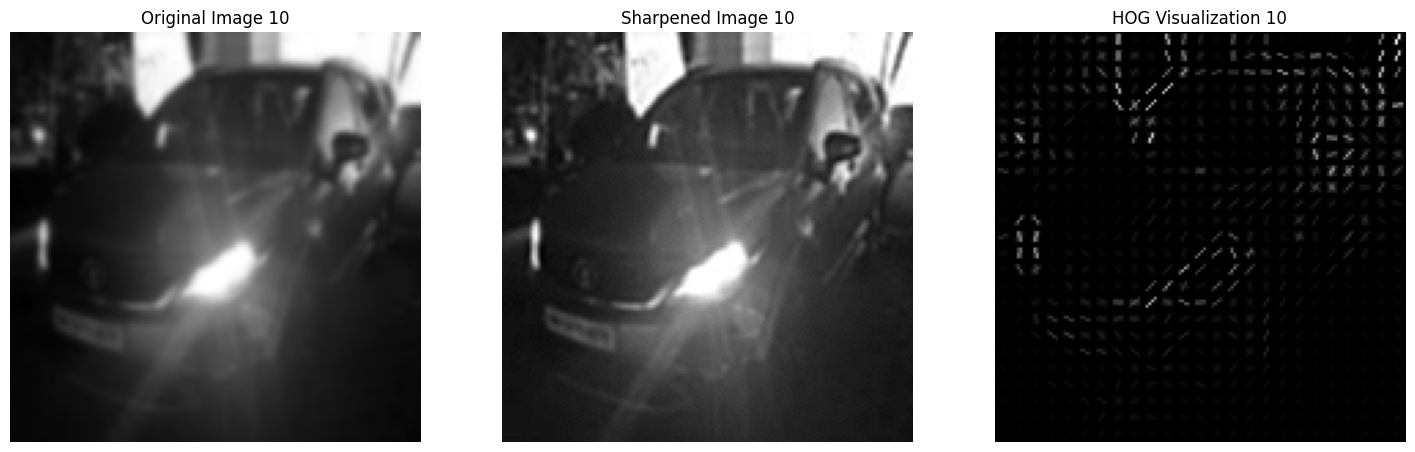

Processing images: 100%|██████████| 8000/8000 [41:58<00:00,  3.18it/s]

Emotion detection After Feature Extraction: 8000


In [11]:
# List to store extracted HOG features
extracted_features = []
images_feature = []

# Parameters for HOG
hog_params = {
    'orientations': 18,  # Increased orientations to capture more detailed gradient information
    'pixels_per_cell': (6, 6),  # Reduced to capture finer gradients
    'cells_per_block': (3, 3),  # Increased cells per block for better normalization
    'block_norm': 'L2-Hys',  # Keeping L2-Hys normalization, but you can experiment with 'L2' or 'L1'
}

# Sharpening filter kernel
sharpening_kernel = np.array([[0, -1, 0],
                               [-1, 5,-1],
                               [0, -1, 0]])

num_samples_to_show = 10

for idx, img in enumerate(tqdm(train_imgs, desc="Processing images")):
    if len(img.shape) == 2:  # Grayscale image
        gray_img = img
    else:  # RGB image
        gray_img = color.rgb2gray(img)  
    
    
    sharpened_img = cv2.filter2D(gray_img, -1, sharpening_kernel)
    
    
    _, hog_image = hog(sharpened_img, visualize=True, **hog_params)
    
    images_feature.append(hog_image.flatten())
    # extracted_features.append(features.flatten())
    
    if idx < num_samples_to_show: 
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title(f'Original Image {idx+1}')
        ax[0].axis('off')
        
        ax[1].imshow(sharpened_img, cmap='gray')
        ax[1].set_title(f'Sharpened Image {idx+1}')
        ax[1].axis('off')
        
        ax[2].imshow(hog_image, cmap='gray')
        ax[2].set_title(f'HOG Visualization {idx+1}')
        ax[2].axis('off')
        
        plt.show()

# Print the total number of extracted features
images_feature = np.array(images_feature)
print(f'Feature Extraction: {len(images_feature)}')


# Split the data

In [14]:
x_train, x_test, y_train, y_test = train_test_split(images_feature, train_labels, train_size=0.75, random_state=64)

print(f'Shape of Training Data: {x_train.shape}')
print(f'Shape of Testing Data: {x_test.shape}')

Shape of Training Data: (6000, 22500)
Shape of Testing Data: (2000, 22500)


In [15]:
x_train[0]

array([250, 253, 255, ..., 235, 244, 248], dtype=uint8)

In [16]:
x_train[0].shape

(22500,)

# Model training

## RandomForestClassifier Model¶

In [16]:
# Random Forest
RandomForest = RandomForestClassifier(n_estimators=170, min_samples_split=3, min_samples_leaf=4, max_depth=15)

RandomForest.fit(x_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=3,
                       n_estimators=170)

In [17]:
# make cross validation
cross_validation = cross_val_score(estimator=RandomForest, X=x_train, y=y_train, scoring="balanced_accuracy",
                                  cv=5, n_jobs=-1)
print(f"The Scores is ==> {cross_validation}")
print("--"*50)
print(f"The Mean Of The Scores is ==> {cross_validation.mean()}")

print("**"*50)

# make cross validation to predict
cross_validation_pred = cross_val_predict(estimator=RandomForest, X=x_train, y=y_train, method="predict",
                                         cv=5, n_jobs=-1)

The Scores is ==> [0.77992799 0.77979465 0.77507751 0.78004467 0.7490499 ]
----------------------------------------------------------------------------------------------------
The Mean Of The Scores is ==> 0.7727789445611227
****************************************************************************************************


<img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/62d92d2524865182802b60ce_K-fold%20cross-validation.jpg" width="1200" height="300">


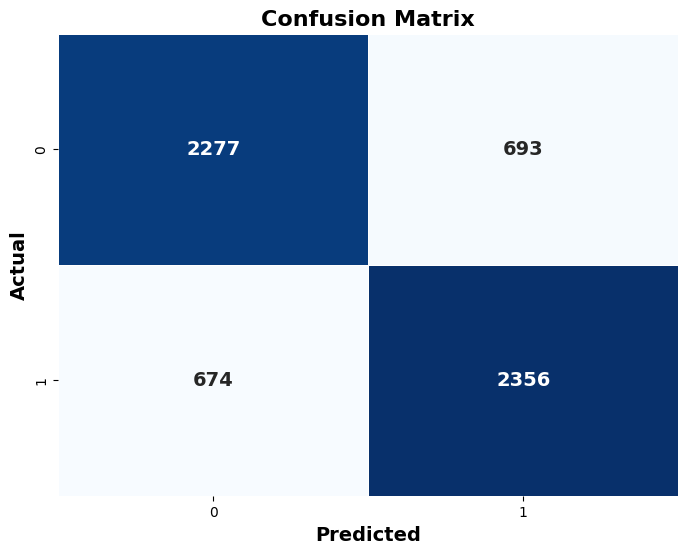

In [18]:
# Compute the confusion matrix
confusion = confusion_matrix(y_train, cross_validation_pred)

# Create a heatmap with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14, 'weight': 'bold'}, linewidths=.5)
# Customize labels and title
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

<img src="https://miro.medium.com/v2/resize:fit:667/1*3yGLac6F4mTENnj5dBNvNQ.jpeg" width="1200" height="300">


In [19]:
# make prediction
y_pred_RandomForest = RandomForest.predict(x_test)
y_pred_RandomForest

array([1, 0, 0, ..., 1, 0, 1])

In [20]:
# prediction
pd.DataFrame(np.c_[y_pred_RandomForest, y_test], columns=["prediction", "Actual"])

prediction  Actual
0              1       1
1              0       0
2              0       0
3              0       1
4              1       0
...          ...     ...
1995           1       0
1996           1       1
1997           1       0
1998           0       0
1999           1       1

[2000 rows x 2 columns]

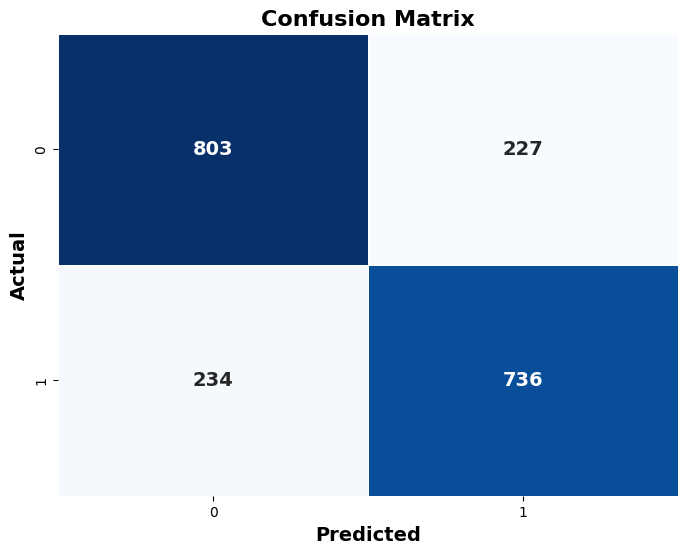

In [21]:
# Compute the confusion matrix on the test
confusion = confusion_matrix(y_test, y_pred_RandomForest)

# Create a heatmap with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14, 'weight': 'bold'}, linewidths=.5)

# Customize labels and title
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [22]:
print("\033[1mThe Classification Report on Test Data\033[0m\n")
classification_rep = classification_report(y_test, y_pred_RandomForest)
print(classification_rep)

The Classification Report on Test Data

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1030
           1       0.76      0.76      0.76       970

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



In [23]:
# the scores
print(f"The Score On The Train => {RandomForest.score(x_train, y_train)*100:0.2f} %")
print(f"The Score On The Test => {RandomForest.score(x_test, y_test)*100:0.2f} %")

The Score On The Train => 99.47 %
The Score On The Test => 76.95 %


In [24]:
import pickle
# Save the model to a file using pickle
with open("RandomForestModel.pkl", "wb") as f:
    pickle.dump(RandomForest, f)

# Deep Learning Model

In [19]:
# Create Model
input_shape = (22500,)
model = Sequential()

model.add(layers.InputLayer(input_shape=input_shape))

model.add(layers.Dense(1024, activation='relu'))  
model.add(layers.Dropout(0.2))  
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 1024)           │    23,041,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,741,031 (90.56 MB)

 Trainable params: 23,741,031 (90.56 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint callback
checkpoint = ModelCheckpoint(
    "best_model.h5.keras",            # Filepath where the model is saved
    monitor='val_loss',         # Monitor validation loss
    save_best_only=True,        # Save only the model with the best performance
    mode='min',                 # Save when 'val_loss' decreases (minimization)
    verbose=1                   # Verbosity mode, to display when a model is saved
)

# Train the model with the checkpoint callback
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint]       
)


Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.3280 - loss: 369.6334
Epoch 1: val_loss improved from inf to 0.76188, saving model to best_model.h5.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 58s 288ms/step - accuracy: 0.3283 - loss: 368.4602 - val_accuracy: 0.5185 - val_loss: 0.7619
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.4688 - loss: 7.3564
Epoch 2: val_loss did not improve from 0.76188
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - accuracy: 0.4689 - loss: 7.3472 - val_accuracy: 0.5105 - val_loss: 0.8578
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.4726 - loss: 3.1993
Epoch 3: val_loss did not improve from 0.76188
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 282ms/step - accuracy: 0.4726 - loss: 3.1938 - val_accuracy: 0.4380 - val_loss: 0.8677
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.4996 - loss: 1.0946
Epoch 4: val_loss did not improve from 0.76188
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - accuracy:

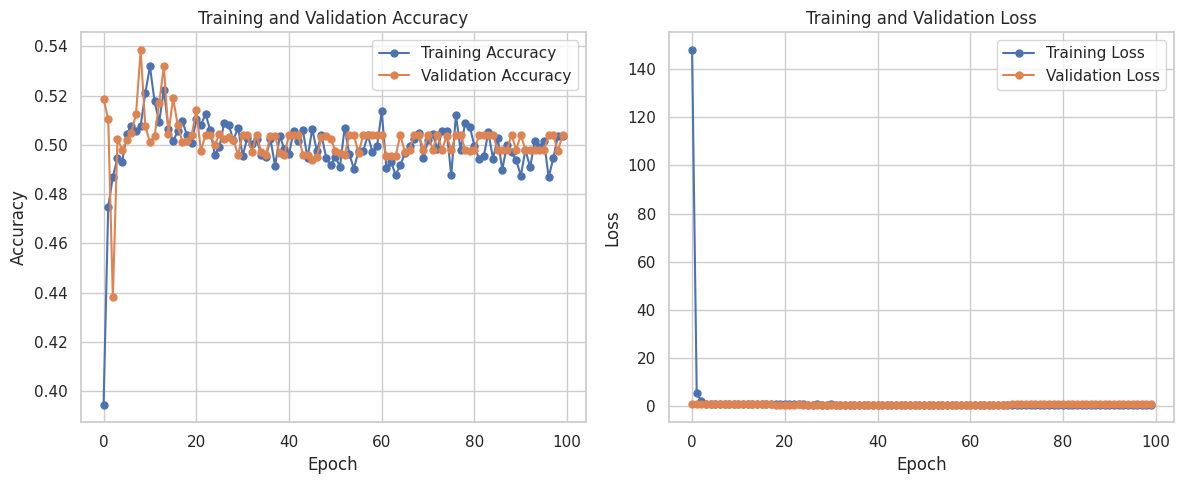

In [21]:
# The style
sns.set(style='whitegrid')

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# use the best model
from tensorflow.keras.models import load_model

# Load the saved model from the file
best_model = load_model('/kaggle/working/best_model.h5.keras')

predictions = best_model.predict(x_test)



63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


In [23]:
predictions

array([[5.0502127e-01, 4.9445027e-01, 7.8196696e-05, ..., 2.4158708e-04,
        1.9821090e-04, 4.1906146e-13],
       [5.0502127e-01, 4.9445027e-01, 7.8196696e-05, ..., 2.4158708e-04,
        1.9821090e-04, 4.1906146e-13],
       [5.0502127e-01, 4.9445027e-01, 7.8196696e-05, ..., 2.4158708e-04,
        1.9821090e-04, 4.1906146e-13],
       ...,
       [5.0502127e-01, 4.9445027e-01, 7.8196696e-05, ..., 2.4158708e-04,
        1.9821090e-04, 4.1906146e-13],
       [5.0502127e-01, 4.9445027e-01, 7.8196696e-05, ..., 2.4158708e-04,
        1.9821090e-04, 4.1906146e-13],
       [5.0502127e-01, 4.9445027e-01, 7.8196696e-05, ..., 2.4158708e-04,
        1.9821090e-04, 4.1906146e-13]], dtype=float32)

In [24]:
# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5085 - loss: 0.6936
Test Accuracy: 50.40%
Test Loss: 69.37%


In [25]:
the_predictions = []
for i in range(len(predictions)):
    the_predictions.append(np.argmax(predictions[i]))
print(the_predictions[:20])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


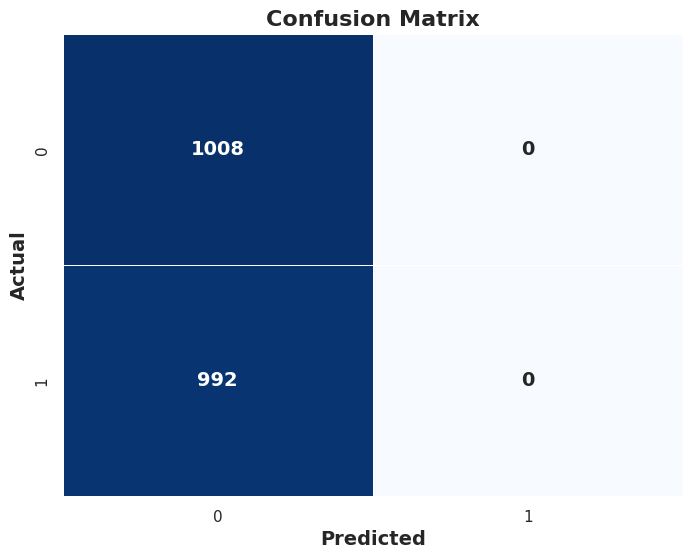

In [26]:
# Compute the confusion matrix
confusion = confusion_matrix(y_test, the_predictions)
# Create a heatmap with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14, 'weight': 'bold'}, linewidths=.5)

# Customize labels and title
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [27]:
print("\033[1mThe Classification Report on Test Data\033[0m\n")
classification_rep = classification_report(y_test, the_predictions)
print(classification_rep)

The Classification Report on Test Data

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1008
           1       0.00      0.00      0.00       992

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.34      2000
weighted avg       0.25      0.50      0.34      2000



In [28]:
model.save("deep_learning_model.h5")